![img](./images/kc_header.png)

(image courtesy of [beautifulwashington.com](https://beautifulwashington.com/king-county.html))

# Analysis of Real Estate Prices and Features in King County, Seattle 

**Authors/contributors:**
- Luke Dowker
- Jawwad Siddiqui
- Xiaohua Su

# Overview

**Recommendations:**

- 1
- 2
- 3

# Business Problem

A real estate agency is looking to provide advice to homeowners looking to increase the values of their homes. We are seeking to identify several variables that can **predict** what a home's sale price can be.

**Alternately:** If a customer is looking to purchase land without a house already on the lot, our recommendations will help home builders maximize their profits by helping builders identify which predictor variables to focus on.

**Note:** Two *separate* audiences - narrow this down!

# Data investigation and cleaning

We kick things off by importing all necessary libraries and packages

In [1]:
# statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
# sci-kit learn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
# baseline analysis and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from random import gauss
# from mpl_toolkits.mplot3d import Axes3D

...and some formatting options.

In [2]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Below, we read in the data and check out some of its basic features: column names, null values, data types, etc.

In [3]:
# Reading in .csv file, creating initial pandas dataframe
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
# Listing out column names
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
# Checking datatypes and null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Two components** of this `info` printout that we can immediately identify as problems we may need to address:

1. Columns currently coded as datatype `object`...

    - `date`
    - `waterfront`
    - `view`
    - `condition`
    - `grade`
    - `sqft_basement`


2. Columns currently containing null values...

    - `waterfront`
    - `view`
    - `yr_renovated`

In [6]:
# Descriptive statistics for numerical columns
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


Looking at the row of `max` values, we can see right away that we have some outliers, values that look as if they depart substantially from the `75%` row; to be more specific, there are some **large, expensive** properties in this dataset.

## Basic data cleaning

First, we convert the column `date` to a more usable format; the code below transforms the column to type `datetime64[ns]`.

In [7]:
# Converting column `date` to datetime64[ns] from type string/object
df['date'] = df['date'].astype('datetime64[ns]')

Likewise, the column `grade` is in object format; it provides both a number and a corresponding descriptor, e.g. `5 Fair`. The following code transforms it to a more usable format, one with no whitespace.

In [8]:
# Clean up the values in column `grade` so they are not
# separated by whitespace
df['grade'] = [x.replace(" ", "_").strip() for x in df['grade']]

In [9]:
# Validating that above code worked as intended
df['grade'].value_counts()

7_Average        8974
8_Good           6065
9_Better         2615
6_Low_Average    2038
10_Very_Good     1134
11_Excellent      399
5_Fair            242
12_Luxury          89
4_Low              27
13_Mansion         13
3_Poor              1
Name: grade, dtype: int64

Every house has a unique `id` value, but does every row in the dataset represent a **unique house?**

In [10]:
# Check for multiples in column `id`
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

Looks like we have a few houses with more than one sale on record! Let's examine a few of the `id` values.

In [11]:
df.loc[(df['id'] == 795000620) |
       (df['id'] == 1825069031) |
       (df['id'] == 2019200220)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3946,1825069031,2014-08-14,550000.00,4,1.75,2410,8447,2.00,NO,GOOD,Good,8_Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
3947,1825069031,2014-10-16,550000.00,4,1.75,2410,8447,2.00,NaN,GOOD,Good,8_Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
12942,2019200220,2014-09-23,160000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7_Average,1160,310.0,1985,0.00,98003,47.27,-122.30,1670,8359
12943,2019200220,2015-02-26,269000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7_Average,1160,310.0,1985,nan,98003,47.27,-122.30,1670,8359
17588,795000620,2014-09-24,115000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5_Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17589,795000620,2014-12-15,124000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5_Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17590,795000620,2015-03-11,157000.00,3,1.00,1080,6250,1.00,NaN,NONE,Fair,5_Fair,1080,0.0,1950,nan,98168,47.50,-122.33,1070,6250


The house with the `id` value `1825069031` saw no change in its sale price between its first sale (in August 2014) and second sale (in October 2014). However, the *other* two houses we're looking at here - `	2019200220` and `795000620` - saw their sale prices **increase** over time, and with no changes in any other column!

It might be best to keep the **most recent** sale on record to avoid adding any additional 'noise' to our model.

In [12]:
# Dropping rows with duplicate values in `id` column,
# sans the most recent sale
df.drop_duplicates(subset=['id'], keep='last', inplace=True)

Let's make sure that worked...

In [13]:
# Ensuring that number of unique `id` values matches
# number of rows in dataframe, i.e. no repeated values
len(df['id'].unique()) == len(df)

True

In [14]:
# Ensuring that only one sale remains for a house
# we know initially had multiple sales on record
df.loc[ df['id'] == 795000620 ]['date']

17590   2015-03-11
Name: date, dtype: datetime64[ns]

We only got one result when indexing into the `date` column for the property `795000620`, and it's the date of the most recent sale on record for `795000620`! We've eliminated *all but the most recent sale* for any property with more than one sale on record.

We no longer have any use for the `id` column, so we can drop it from our dataframe entirely.

In [15]:
# Dropping `id` column, now that we know we
# have exclusively unique values for `id`

df.drop(labels='id',
        axis=1,
        inplace=True)

**Something else that might be of note:** in some of these rows where the same `id` appears twice, a value that *was* recorded in the first sale appears as a *null value* in a later sale, e.g. the `waterfront` column on the house whose `id` is `1825069031`.

<AxesSubplot:>

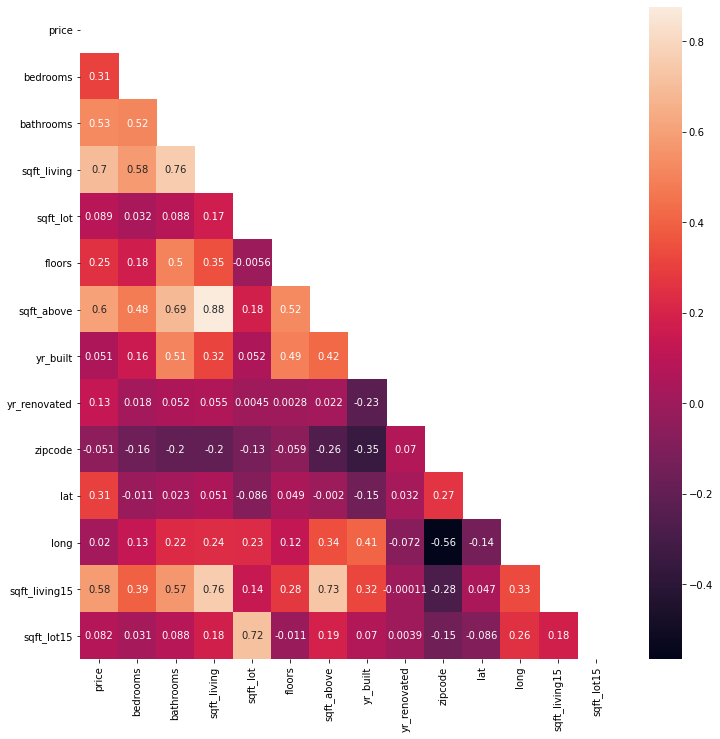

In [16]:
# Visualizing correlations between numerical columns
# with a seaborn heatmap to investigate the correlation
# of various features w/ `price` and assess potential
# issues with multicollinearity

fig, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()

# Instantiate numpy array of zeroes and assign to `mask`
mask = np.zeros_like(corr,
                     dtype=bool)

# Returns indices from upper triangle of array
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            annot=True,
            mask=mask)

**Observations from this heatmap:**

- `sqft_living` has the highest correlation with price, an r-value of `0.7`...
    - ...but `sqft_living` is also correlated with several other columns: `bedrooms`, `bathrooms`, `sqft_above` (this one has an r-value of `0.88`!), and `sqft_living15`, so we'll need to be careful that we don't include collinear features in our models.
- `zipcode`, `lat`, and `long` all have low (`0.31` or below) correlations with `price` - these columns likely won't be useful to us in constructing models for this project, but could be worth looking into as next-step recommendations.

In [38]:
# Creating copy of original dataframe before dropping columns
df_copy = df.copy()

In [39]:
# Drop irrelevant columns
df_copy.drop(columns=['date',
                      'floors',
                      'waterfront',
                      'condition',
                      'sqft_above',  # potential for multicollinearity
                      'sqft_basement',  # potential for multicollinearity
                      'yr_renovated',
                      'lat',
                      'long',
                      'sqft_living15',  # potential for multicollinearity
                      'sqft_lot15'],
             inplace=True)

In [40]:
# mms = MinMaxScaler()
# df_copy[['bathrooms']] = mms.fit_transform(df_copy[['bathrooms']])

In [41]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21420 non-null  float64
 1   bedrooms     21420 non-null  int64  
 2   bathrooms    21420 non-null  float64
 3   sqft_living  21420 non-null  int64  
 4   sqft_lot     21420 non-null  int64  
 5   view         21357 non-null  object 
 6   grade        21420 non-null  object 
 7   yr_built     21420 non-null  int64  
 8   zipcode      21420 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


We've got some nulls in the `view` column, but the number of null values *vis-à-vis*  the number of total rows in the dataframe is such that we can safely drop those nulls without worrying about our conclusions being affected.

In [42]:
# Dropping nulls from column `view`
df_copy = df_copy.dropna(subset = ['view'])

In [43]:
# Validating that...
df_copy['view'].isna().sum() == 0

True

`view` and `grade` might seem similar on first glance - both columns use descriptors like `AVERAGE` and `GOOD` to assess the attributes of a house - but we determined that `grade` is a much more mutable category; it refers to the "types of materials used (in building the house) and the quality of workmanship" on display in the house's "construction and design."

Let's get a breakdown of the distribution of `grade` values in King County.

In [44]:
# Checking out the frequency of each possible value
# for column `grade`
df_copy['grade'].value_counts()

7_Average        8863
8_Good           6029
9_Better         2595
6_Low_Average    1988
10_Very_Good     1126
11_Excellent      394
5_Fair            234
12_Luxury          87
4_Low              27
13_Mansion         13
3_Poor              1
Name: grade, dtype: int64

We find only **one row** where the `grade` value is equal to `3 Poor`. We drop this column to eliminate an outlier.

In [45]:
# Dropping the single row where `grade` is equal to
# `3 Poor`, in order to eliminate an outlier
df_copy = df_copy[df_copy['grade'] != '3 Poor']

In [46]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21357 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21357 non-null  float64
 1   bedrooms     21357 non-null  int64  
 2   bathrooms    21357 non-null  float64
 3   sqft_living  21357 non-null  int64  
 4   sqft_lot     21357 non-null  int64  
 5   view         21357 non-null  object 
 6   grade        21357 non-null  object 
 7   yr_built     21357 non-null  int64  
 8   zipcode      21357 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


All set to begin preprocessing!

In [48]:
# df_copy['sqft_living'] = np.log(df_copy['sqft_living'])

# Splitting data into train and test sets

Our **target** variable, or `X`, is going to be `price`, i.e. the sale price of a given home.

In [49]:
# Creating target variable and predictor dataframe
y = df_copy['price']
X = df_copy.drop(labels='price',
                 axis=1)

In [50]:
y2 = y
X2 = X['sqft_living']

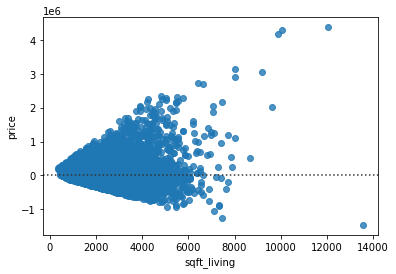

In [51]:
# Viewing residuals of sqft_living vs. price
sns.residplot(x=X2, y=y2);

In [ ]:
# Initiating train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
# Check out `X_train`
X_train.info()

In [ ]:
X_train.shape[0] == y_train.shape[0]

In [ ]:
X_test.shape[0] == y_test.shape[0]

In [ ]:
# Creating concatenated dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [ ]:
train_df.head();

In [ ]:
test_df.head();

Below, we group the dataset by column `view` and get some descriptive statistics on the column.

In [ ]:
# df_copy.groupby('view').mean()
# df_copy.sort_values('price', ascending = False).head()

In [ ]:
# fig, ax = plt.subplots(figsize=(20,10))

# sns.histplot(df_copy['grade'])

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# heat = sns.heatmap(train_df.corr(), annot = True)

## Baseline Model (using DummyRegressor)

In [52]:
# Instantiate the DummyRegressor
dummy_lr = DummyRegressor(strategy='median')

# Create variables
X_dummy = train_df['sqft_living']
y_dummy = train_df['price']

# Fit regressor to variables
dummy_lr.fit(X_dummy, y_dummy)

# Score
dummy_lr.score(X_dummy, y_dummy)

NameError: name 'train_df' is not defined

In [ ]:
dummy_lr.constant_

## Initial Model

In [ ]:
# Using statsmodel.OLS to create our first model,
# with a single feature (sqft_living)
simple_model_1 = sm.OLS(y_train, sm.add_constant(X_train['sqft_living'])).fit()

In [ ]:
simple_model_1.summary()

In [ ]:
# Grabbing predictions from simple linear model
simple_train_preds_1 = simple_model_1.predict(sm.add_constant(X_train['sqft_living']))

simple_train_preds_1

In [ ]:
# First round of residuals
residuals_1 = y_train - simple_train_preds_1

residuals_1

### View Analysis

is there a difference between those that have a view versus those that don't

In [ ]:
summary_of_view = df_copy.groupby('view').agg(['mean', 'std'])

summary_of_view

Observations from this summary:

- Significant gap between `EXCELLENT` and `GOOD`
- Smallest gap is between `FAIR` and `AVERAGE` - we'll need to determine if this difference is a signficant one.

From the df summary, we notice that there is a difference in price between price for those that are excellent
compared to those that have a view written as none. Further investigation will be performed to determine if this
difference is statistically significant

In [ ]:
# Figure out how to do this in a loop/function?
df_average = train_df[train_df['view'] == 'AVERAGE']
df_excellent = train_df[train_df['view'] == 'EXCELLENT']
df_fair = train_df[train_df['view'] == 'FAIR']
df_good = train_df[train_df['view'] == 'GOOD']
df_none = train_df[train_df['view'] == 'NONE']

In [ ]:
train_df['view'].value_counts()

Subsetting the data into different views
 - Number of rows:
     - `NONE` = 12906
     - `AVERAGE` = 636
     - `GOOD` = 342
     - `FAIR` = 213
     - `EXCELLENT` = 212

In [ ]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [ ]:
#creating df of just view
# df_view = train_df[['view', 'price']]

#Tukey test
#print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

`AVERAGE` and `FAIR` are not significant to each other, so they should be grouped together. Each other subset should be on their own as they have a p value of < .05

#### Grade Analysis

 Is there a difference between grades

In [ ]:
train_df.grade.value_counts()

In [ ]:
# Dropping poor row, since there is only one
df3 = train_df.copy()
df3 = df3[df3['grade'] != '3 Poor']

In [ ]:
df3.grade = [x.replace(" ", "_").strip() for x in df3.grade]

In [ ]:
df3['grade'].value_counts()

In [ ]:
# Might need a for loop or a function here
df_10 = train_df[train_df['grade'] == '10 Very Good']
df_11 = train_df[train_df['grade'] == '11 Excellent']
df_12 = train_df[train_df['grade'] == '12 Luxury']
df_4 = train_df[train_df['grade'] == '4 Low']
df_5 = train_df[train_df['grade'] == '5 Fair']
df_6 = train_df[train_df['grade'] == '6 Low Average']
df_7 = train_df[train_df['grade'] == '7 Average']
df_8 = train_df[train_df['grade'] == '8 Good']
df_9 = train_df[train_df['grade'] == '9 Better']

In [ ]:
# Finding f-statistic and p-value using ANOVA testing

f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'], df_12['price'],
                                              df_4['price'], df_5['price'], df_6['price'],
                                              df_7['price'], df_8['price'], df_9['price'])
p_value_grade

This 0.0 value indicates there is significance **somewhere** between `grade` values, but additional testing is required to determine **where** exactly this significance exists.

There is a significant difference in price betweeen grades but we don't know which one is significant.
Further testing required to determine which is important

In [ ]:
# Ad-hoc test to determine differeces in price vs. grade

df_grade = train_df[['grade', 'price']]

print(pairwise_tukeyhsd(df_grade['price'], df_grade['grade']))

Summary of what we notice

#### One Hot Encoding | Rework to include Train only

In [ ]:
#categorizing average and fair together since they are not different from each other
df3['view'] = df3['view'].str.replace('AVERAGE', 'FAIR')

In [ ]:
#making the categorical variable
cate_column = df3[['grade', 'view']]

cate_column

In [ ]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

In [ ]:
name = ohe.get_feature_names_out()

In [ ]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name, index = features.index)
cate_parsed

### Scaling | Rework only to include train

In [ ]:
# Creating dataframe with only numerical columns
numbers = train_df.select_dtypes(np.number)

In [ ]:
#Rework to include only the train_df
ss = StandardScaler()

columns_name1 = ['price', 'sqft_living']
numbers_scaling = numbers.copy()

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

In [ ]:
#combinig scale and ohe
scaled_and_parse_df = pd.concat([numbers_scaling, cate_parsed], axis = 1)

In [ ]:
scaled_and_parse_df.columns = [x.replace(" ", "_").strip() for x in scaled_and_parse_df.columns]

## Linear Regression | Rework so fit is only on train and not test

#### simple linear

In [ ]:
fig, ax = plt.subplots()

x = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']


ax.scatter(x, y);

In [ ]:
np.corrcoef(df['sqft_living'],df['price'])

Passing our first assumption: Based on our scatterplot, we can see that there is a strong correlation between `sqft_living` and price. Our pearson correlation coefficiant of `.70` suggests that these two variables are strongly correlated. Refer to the heatmap above re: multicollinearity.

In [ ]:
# Baseline model
# Import necessary package
from sklearn.dummy import DummyRegressor

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']

# Fit
dummy_lr.fit(X,y)

# Score
dummy_lr.score(X,y)

In [ ]:
#Define X and y variable using scaled & parse dataframe

X_s_p = scaled_and_parse_df[['sqft_living']]
y_s_p = scaled_and_parse_df[['price']]

In [ ]:
# ^^^ Test DF must also be scaled and parsed

In [ ]:
sk_lr = LinearRegression()
sk_lr.fit(X_s_p, y_s_p)
preds = sk_lr.predict(y_s_p)

preds

In [ ]:
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df[['price']]

In [ ]:
resids = y - preds
resids

In [ ]:
#Create out bins

bins = int( len(X)**.5)
bins

In [ ]:
# Histogram of residuals

plt.hist(resids, bins=bins);

In [ ]:
print(resids.max())
resids.min()

In [ ]:
sns.displot(resids, bins=bins, kde=True)

In [ ]:
sm.qqplot(resids, line='r');

In [ ]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

In [ ]:
plt.scatter(preds, resids);

In [ ]:
#Fit the dummy_regressor

dummy_lr.fit(X_s_p,y_s_p)

In [ ]:
# Score it

dummy_lr.score(X_s_p,y_s_p)

In [ ]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula,
                   data = scaled_and_parse_df).fit()
simple_mod_summ = simple_model.summary()

simple_mod_summ

In [ ]:
#test on our test data set

Summary comparison between the two

#### Multiple regression | Rework to train data

Slowly adding in other variables

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

x1 = scaled_and_parse_df[['sqft_living']]
y1 = scaled_and_parse_df[['price']]

# x2 = scaled_and_parse_df[['bedrooms']]

ax[0].scatter(x1, y1)
# ax[1].scatter(x2,y1);

#Upon looking at our scaled dataframe, we noticed that there is a house sold with 33 bedrooms for $600k
#After considering the price sold, sqft and number of bathrooms - the # of bedrooms appears 
#to be an error of somesort
#Since we explored bedrooms having a relatively small correlation to price, we are not too worried about this one
#outlier being included in our scatterplot

In [ ]:
simple_formula3 = 'price ~ sqft_living'
simple_model3 = ols(formula = simple_formula3,
                   data = scaled_and_parse_df).fit()
simple_mod_summ3 = simple_model3.summary()

simple_mod_summ3

In [ ]:
scaled_and_parse_df.head()

In [ ]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

The above model has an adjusted R-squared value of 0.623 suggesting that this model accounts for roughly ~10-15% more variance.

In [ ]:
simple_formula4 = 'price ~ view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

In [ ]:
simple_formula4 = 'price ~ sqft_living + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

In [ ]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD + view_NONE'

simple_model4 = ols(formula=simple_formula4,
                    data=scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

It appears that our model is the strongest when we are comparing `sqft_living` + `view` + `grade` with an adjusted R-squared of 0.623.


## Next Steps:

- `bathrooms` and `bedrooms` - they are collinear with variables like `sqft_living`, which prevented us from including them in our model, but they might be useful avenues for further exploration.
- `waterfront` - our EDA demonstrated a significant difference in `price` between homes with waterfront views vs. homes without; it may be worth further exploring what development opportunities exist in waterfront areas.
- `zipcode` - taking a look at what neighborhoods/geographic areas yield high sale prices.
    - Look at interaction items: if homes with `EXCELLENT` views are concentrated in certain areas, perhaps.

# Unused Code

In [37]:
# Log transform `sqft_living` column
# df_copy['sqft_living'] = np.log(df_copy['sqft_living'])

In [53]:
# Scale `bathrooms` column on 0 to 1 min-max
# mms = MinMaxScaler()
# df_copy[['bathrooms']] = mms.fit_transform(df_copy[['bathrooms']])